# Zillow House Price Feature Selection



## Introduction

Zillow as one of the largest marketplaces for real estate information in the U.S, it’s Zestimate is a prediction of a property value. Zillow hosted a [Kaggle Competition](https://www.kaggle.com/c/zillow-prize-1/data) with over a million in prizes to get ideas to improve their Zestimate. 

First Round Prizes: $50,000 U.S. Dollars ("USD") total           
   
* First Place Prize - $25,000 USD   
* Second Place Prize - $15,000 USD  
* Third Place Prize - $10,000 USD      

_As a condition to receipt of a prize, each First Round prize winner must agree to grant Sponsor a non-exclusive license to their winning Submission._

Second Round Prizes: $1,150,000 USD Total   

* First Place Prize - $1,000,000 USD    
* Second Place Prize - $100,000 USD      
* Third Place Prize - $50,000 USD      

_As a condition of receipt of a prize, each Second Round prize winner must (1) beat the Zillow benchmark model (as described below) and (2) deliver the final model’s software code as used to generate their winning Submission and associated documentation (consistent with the winning model documentation template available on the Kaggle wiki at https://www.kaggle.com/wiki/WinningModelDocumentationTemplate) to the Sponsor. The delivered software code must be capable of generating the winning Submission and contain a description of resources required to build and/or run the executable code successfully. For clarity, if no Participants beat the Zillow benchmark model, Sponsor is not required to award any prizes in the Second Round._

## Data 

Our data is getting from [Kaggle Competition](https://www.kaggle.com/c/zillow-prize-1/data), 6 csv files and corresponding descriptions are included:
- properties_2016.csv: all the properties with their home features for 2016. Note: Some 2017 new properties don't have any data yet except for their parcelid's. Those data points should be populated when properties_2017.csv is available.
- properties_2017.csv: all the properties with their home features for 2017 (released on 10/2/2017)
- sample_submission.csv: a sample submission file in the correct format
- train_2016_v2.csv: the training set with transactions from 1/1/2016 to 12/31/2016
- train_2017.csv: the training set with transactions from 1/1/2017 to 9/15/2017 (released on 10/2/2017)


In [232]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math
import h5py
import warnings
from tensorflow.python.framework import ops
warnings.filterwarnings('ignore')
%matplotlib inline

In [233]:
target='logerror'
min_mem_size=6 
run_time=333

In [234]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

4


In [235]:
# 65535 Highest port no
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:41636..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-macosx) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-macosx) (build 25.121-b15, mixed mode)
  Starting server from /Users/bear/anaconda/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmp72x9ll02
  JVM stdout: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmp72x9ll02/h2o_bear_started_from_python.out
  JVM stderr: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmp72x9ll02/h2o_bear_started_from_python.err
  Server is running at http://127.0.0.1:41636
Connecting to H2O server at http://127.0.0.1:41636... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,24 days
H2O cluster name:,H2O_from_python_bear_a4nz3l
H2O cluster total nodes:,1
H2O cluster free memory:,3.833 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


#### Read the Evaluation Data 

In [236]:
# read the evaluation data
properties_2016_eval = pd.read_csv('zillow-prize-1/train_2016_v2.csv')

# show the head of evaluation data
properties_2016_eval.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


The evaluation data only includes 3 different columns:
- parcelid
- logerror
- transactiondate

According to the Evaluation idea in kaggle, we know that Submissions are evaluated on Mean Absolute Error between the predicted log error and the actual log error. The log error is defined as:   
> logerror = log (Zestimate) − log (SalePrice)

As for the parcelid, it is id for each row of data(unique parcelid).
And as for the transactiondate, it restricts the date we need to predict and submit in csv file. As a parcel can be sold many times we want to predict prices each time its sold.

_This is not training data.  We will create predictions and use this file to estimate how well our estimate, called Bearstimates come to Zillow's  Zestimates._


In [237]:
# read the property data from properties_2016 file
properties_2016 = pd.read_csv('zillow-prize-1/properties_2016.csv')

In [238]:
properties_2016.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [239]:
# read the property data from properties_2016 file
data_file='zillow-prize-1/properties_2016.csv'
properties_2016 = pd.read_csv(data_file)

# show the head of property data
properties_2016.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In the properties file, we can see there are 58 colunms. According to zillow data dictionary each field is as follows:
- 'airconditioningtypeid'	 Type of cooling system present in the home (if any)
- 'architecturalstyletypeid'	 Architectural style of the home (i.e. ranch, colonial, split-level, etc…)
- 'basementsqft'	 Finished living area below or partially below ground level
- 'bathroomcnt'	 Number of bathrooms in home including fractional bathrooms
- 'bedroomcnt'	 Number of bedrooms in home 
- 'buildingqualitytypeid'	 Overall assessment of condition of the building from best (lowest) to worst (highest)
- 'buildingclasstypeid'	The building framing type (steel frame, wood frame, concrete/brick) 
- 'calculatedbathnbr'	 Number of bathrooms in home including fractional bathroom
- 'decktypeid'	Type of deck (if any) present on parcel
- 'threequarterbathnbr'	 Number of 3/4 bathrooms in house (shower + sink + toilet)
- 'finishedfloor1squarefeet'	 Size of the finished living area on the first (entry) floor of the home
- 'calculatedfinishedsquarefeet'	 Calculated total finished living area of the home 
- 'finishedsquarefeet6'	Base unfinished and finished area
- 'finishedsquarefeet12'	Finished living area
- 'finishedsquarefeet13'	Perimeter  living area
- 'finishedsquarefeet15'	Total area
- 'finishedsquarefeet50'	 Size of the finished living area on the first (entry) floor of the home
- 'fips'	 Federal Information Processing Standard code -  see https://en.wikipedia.org/wiki/FIPS_county_code for more details
- 'fireplacecnt'	 Number of fireplaces in a home (if any)
- 'fireplaceflag'	 Is a fireplace present in this home 
- 'fullbathcnt'	 Number of full bathrooms (sink, shower + bathtub, and toilet) present in home
- 'garagecarcnt'	 Total number of garages on the lot including an attached garage
- 'garagetotalsqft'	 Total number of square feet of all garages on lot including an attached garage
- 'hashottuborspa'	 Does the home have a hot tub or spa
- 'heatingorsystemtypeid'	 Type of home heating system
- 'latitude'	 Latitude of the middle of the parcel multiplied by 10e6
- 'longitude'	 Longitude of the middle of the parcel multiplied by 10e6
- 'lotsizesquarefeet'	 Area of the lot in square feet
- 'numberofstories'	 Number of stories or levels the home has
- 'parcelid'	 Unique identifier for parcels (lots) 
- 'poolcnt'	 Number of pools on the lot (if any)
- 'poolsizesum'	 Total square footage of all pools on property
- 'pooltypeid10'	 Spa or Hot Tub
- 'pooltypeid2'	 Pool with Spa/Hot Tub
- 'pooltypeid7'	 Pool without hot tub
- 'propertycountylandusecode'	 County land use code i.e. it's zoning at the county level
- 'propertylandusetypeid'	 Type of land use the property is zoned for
- 'propertyzoningdesc'	 Description of the allowed land uses (zoning) for that property
- 'rawcensustractandblock'	 Census tract and block ID combined - also contains blockgroup assignment by extension
- 'censustractandblock'	 Census tract and block ID combined - also contains blockgroup assignment by extension
- 'regionidcounty'	County in which the property is located
- 'regionidcity'	 City in which the property is located (if any)
- 'regionidzip'	 Zip code in which the property is located
- 'regionidneighborhood'	Neighborhood in which the property is located
- 'roomcnt'	 Total number of rooms in the principal residence
- 'storytypeid'	 Type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.).  See tab for details.
- 'typeconstructiontypeid'	 What type of construction material was used to construct the home
- 'unitcnt'	 Number of units the structure is built into (i.e. 2 = duplex, 3 = triplex, etc...)
- 'yardbuildingsqft17'	Patio in  yard
- 'yardbuildingsqft26'	Storage shed/building in yard
- 'yearbuilt'	 The Year the principal residence was built 
- 'taxvaluedollarcnt'	The total tax assessed value of the parcel
- 'structuretaxvaluedollarcnt'	The assessed value of the built structure on the parcel
- 'landtaxvaluedollarcnt'	The assessed value of the land area of the parcel
- 'taxamount'	The total property tax assessed for that assessment year
- 'assessmentyear'	The year of the property tax assessment 
- 'taxdelinquencyflag'	Property taxes for this parcel are past due as of 2015
- 'taxdelinquencyyear'	Year for which the unpaid propert taxes were due 

Obviously, we can not use every column of data. Because some data has too many missing values, some data is not suitable for the prediction and some data can be calculated by some other data. So we need to do the data cleaning.

### Create properties data and convert it to an H20 dataframe

Note that we want an inner join as we only want a parcelid with a logerror

In [240]:
# Merge the properties and trian data
df = pd.merge(properties_2016, properties_2016_eval, on='parcelid', how='inner')

In [241]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,17073783,NaN,NaN,NaN,2.5,3.0,NaN,NaN,2.5,NaN,...,115087.0,191811.0,2015.0,76724.0,2015.06,NaN,NaN,6.111002e+13,0.0953,2016-01-27
1,17088994,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,143809.0,239679.0,2015.0,95870.0,2581.30,NaN,NaN,6.111002e+13,0.0198,2016-03-30
2,17100444,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,33619.0,47853.0,2015.0,14234.0,591.64,NaN,NaN,6.111001e+13,0.0060,2016-05-27
3,17102429,NaN,NaN,NaN,1.5,2.0,NaN,NaN,1.5,NaN,...,45609.0,62914.0,2015.0,17305.0,682.78,NaN,NaN,6.111001e+13,-0.0566,2016-06-07
4,17109604,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,...,277000.0,554000.0,2015.0,277000.0,5886.92,NaN,NaN,6.111001e+13,0.0573,2016-08-08


In [242]:
df.shape

(90275, 60)

In [246]:
df['logerror'].head()

0    0.0953
1    0.0198
2    0.0060
3   -0.0566
4    0.0573
Name: logerror, dtype: float64

In [247]:
df['logerror'].describe()

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64

In [248]:
# conversion of pandas dataframe to h2o frame
hf = h2o.H2OFrame(df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [249]:
hf.describe()

Rows:90275
Cols:60




,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
type,int,enum,enum,enum,real,int,enum,int,real,enum,enum,int,int,enum,enum,enum,enum,int,enum,int,enum,enum,enum,int,int,int,real,enum,enum,enum,enum,enum,int,int,enum,real,int,int,enum,int,int,enum,enum,enum,int,enum,enum,int,enum,enum,int,int,int,int,real,enum,enum,int,real,time
mins,10711738.0,,,,0.0,0.0,,1.0,1.0,,,2.0,2.0,,,,,6037.0,,1.0,,,,1.0,33339295.0,-119447865.0,167.0,,,,,,0.0,31.0,,60371011.101001,3491.0,1286.0,,95982.0,0.0,,,,1.0,,,1885.0,,,100.0,22.0,2015.0,22.0,49.08,,,60371011101001.0,-4.605,1451606400000.0
mean,12984656.108712273,,,,2.279473829964004,3.0318692882857903,,5.56540687539223,2.3092162122725703,,,1773.1859865645972,1745.4545305855427,,,,,6048.870551093871,,2.241231073148282,,,,3.9269793152639108,34005410.69369153,-118198868.30685127,29110.164176624,,,,,,202.6997234028199,261.83217945167587,,60491794.811502874,33761.332851071544,2525.420769869842,,96586.1311835106,1.4785156466352813,,,,1.1104142032114885,,,1968.5328701169585,,,180093.39374826167,457672.6273567132,2015.0,278335.3250216003,5983.975926730117,,,60491508546032.64,0.011457219606757121,1465669839260.0388
maxs,162960842.0,,,,20.0,16.0,,12.0,20.0,,,22741.0,20013.0,,,,,6111.0,,20.0,,,,24.0,34816009.0,-117554924.0,6971010.0,,,,,,8800.0,275.0,,61110091.00101999,396556.0,3101.0,,399675.0,18.0,,,,143.0,,,2015.0,,,9948100.0,27750000.0,2015.0,24500000.0,321936.09,,,61110091001020.0,4.737,1483056000000.0
sigma,2504510.488301767,,,,1.0042709877071905,1.1564355198675524,,1.9006016285969731,0.9761724992343213,,,928.1623927208233,909.9411657489271,,,,,20.663460805186414,,0.9631416217273226,,,,3.6843820505313793,264965.37555690156,360603.19970355544,121721.30865440037,,,,,,307.47152682954317,5.182900523458312,,205054.86726826307,46672.39386291222,805.6948419923104,,3661.3390937511517,2.819627043522205,,,,0.7972352624935555,,,23.76347471454321,,,209129.88816860024,554884.3989425417,0.0,400495.4648926158,6838.876956292304,,,204660503527.13788,0.1610788353671869,7410679638.77166
zeros,0,,,,1165,1421,,0,0,,,0,0,,,,,0,,0,,,,0,0,0,0,,,,,,1,0,,0,0,0,,0,69700,,,,0,,,0,,,0,0,0,0,0,,,0,847,0
missing,0,0,0,0,0,0,0,32911,1182,0,0,661,4679,0,0,0,0,0,0,1182,0,0,0,34195,0,0,10150,0,0,0,0,0,16160,0,0,0,1803,0,0,35,0,0,0,0,31922,0,0,756,0,0,380,1,0,1,6,0,0,605,0,0
0,17073783.0,nan,nan,nan,2.5,3.0,nan,nan,2.5,nan,548.0,1264.0,1264.0,nan,nan,548.0,nan,6111.0,nan,2.0,2.0,0.0,nan,nan,34303597.0,-119287236.0,1735.0,nan,nan,nan,nan,nan,1128.0,265.0,nan,61110022.003006995,34543.0,2061.0,nan,97081.0,5.0,nan,1.0,nan,nan,128.0,nan,1986.0,2.0,nan,115087.0,191811.0,2015.0,76724.0,2015.06,nan,nan,61110022003007.0,0.0953,2016-01-27 00:00:00
1,17088994.0,nan,nan,nan,1.0,2.0,nan,nan,1.0,nan,777.0,777.0,777.0,nan,nan,777.0,nan,6111.0,nan,1.0,1.0,0.0,nan,nan,34272866.0,-119198911.0,nan,nan,nan,nan,nan,nan,1129.0,266.0,nan,61110015.031002,34543.0,2061.0,nan,97083.0,4.0,nan,nan,nan,nan,198.0,nan,1990.0,1.0,nan,143809.0,239679.0,2015.0,95870.0,2581.3,nan,nan,61110015031002.0,0.0198,2016-03-30 00:00:00
2,17100444.0,nan,nan,nan

In [250]:
def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x

In [251]:
y=target
X=get_independent_variables(hf,y) 
print(X)
print(y)

['parcelid', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips', 'fullbathcnt', 'heatingorsystemtypeid', 'latitude', 'longitude', 'propertycountylandusecode', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 'censustractandblock', 'airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertyzoningdesc', 'regionidneighborhood', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag', 'tax

In [252]:
train, valid = hf.split_frame([0.90])

In [253]:
# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time,exclude_algos = ['DeepLearning'])

In [254]:
aml.train(x=X,y=y,training_frame=train) 

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [255]:
print(aml.leaderboard)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20190218_225558,0.0253171,0.159114,0.0253171,0.0682536,nan
StackedEnsemble_BestOfFamily_AutoML_20190218_225558,0.0253171,0.159114,0.0253171,0.0682536,nan
XGBoost_1_AutoML_20190218_225558,0.0254222,0.159444,0.0254222,0.0684169,nan
XRT_1_AutoML_20190218_225558,0.0255347,0.159796,0.0255347,0.06863,nan
GLM_grid_1_AutoML_20190218_225558_model_1,0.0255774,0.159929,0.0255774,0.0681765,nan
DRF_1_AutoML_20190218_225558,0.0257977,0.160617,0.0257977,0.0702727,nan


In [256]:
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [257]:
aml_leaderboard_df['model_id']

0     StackedEnsemble_AllModels_AutoML_20190218_225558
1    StackedEnsemble_BestOfFamily_AutoML_20190218_2...
2                     XGBoost_1_AutoML_20190218_225558
3                         XRT_1_AutoML_20190218_225558
4            GLM_grid_1_AutoML_20190218_225558_model_1
5                         DRF_1_AutoML_20190218_225558
Name: model_id, dtype: object

In [258]:
models_dict={}
for m in aml_leaderboard_df['model_id']:
     print(m)
     models_dict[m]=None        
  

StackedEnsemble_AllModels_AutoML_20190218_225558
StackedEnsemble_BestOfFamily_AutoML_20190218_225558
XGBoost_1_AutoML_20190218_225558
XRT_1_AutoML_20190218_225558
GLM_grid_1_AutoML_20190218_225558_model_1
DRF_1_AutoML_20190218_225558


In [259]:
models_dict

{'DRF_1_AutoML_20190218_225558': None,
 'GLM_grid_1_AutoML_20190218_225558_model_1': None,
 'StackedEnsemble_AllModels_AutoML_20190218_225558': None,
 'StackedEnsemble_BestOfFamily_AutoML_20190218_225558': None,
 'XGBoost_1_AutoML_20190218_225558': None,
 'XRT_1_AutoML_20190218_225558': None}

In [260]:
def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id 

In [261]:
mod,mod_id=get_model_by_algo("DRF",models_dict)

DRF_1_AutoML_20190218_225558
drf


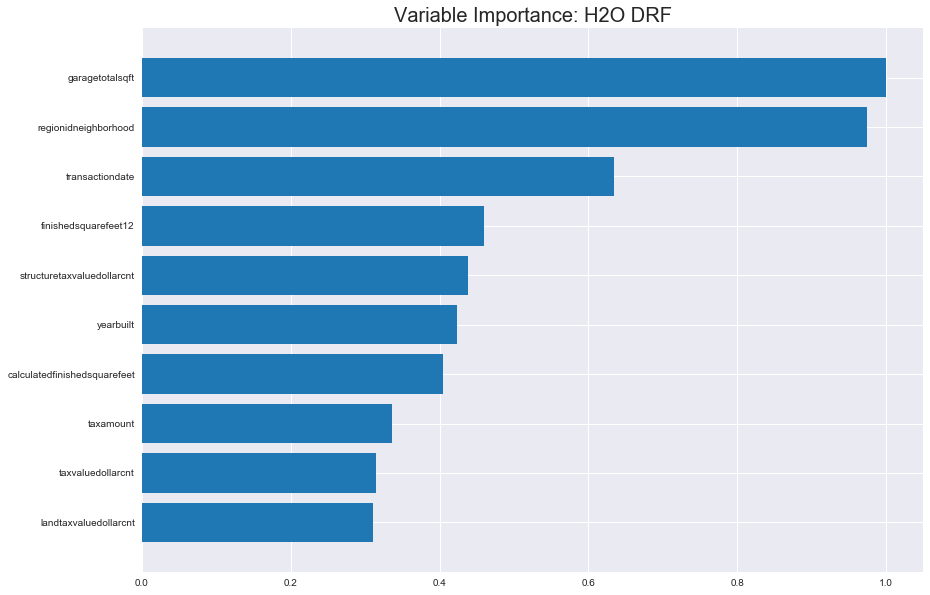

In [262]:
if mod is not None:
  print(mod_id)
  print(mod.algo)
  mod.varimp_plot()    

In [263]:
if mod is not None:
  print(mod.varimp())

[('garagetotalsqft', 2526.961181640625, 1.0, 0.11224990912048484), ('regionidneighborhood', 2461.303466796875, 0.9740171256603468, 0.10933333383716978), ('transactiondate', 1604.8946533203125, 0.635108550531171, 0.0712908770787668), ('finishedsquarefeet12', 1162.1513671875, 0.4599007597073475, 0.05162381848159169), ('structuretaxvaluedollarcnt', 1106.5487060546875, 0.43789699426101303, 0.049153897809932186), ('yearbuilt', 1070.215087890625, 0.42351861028422677, 0.04753992551523849), ('calculatedfinishedsquarefeet', 1022.011962890625, 0.4044430798209118, 0.04539869895430635), ('taxamount', 849.593994140625, 0.3362117314319121, 0.037739736298472985), ('taxvaluedollarcnt', 796.4660034179688, 0.31518727284162895, 0.03537974273240631), ('landtaxvaluedollarcnt', 786.174560546875, 0.3111146171372734, 0.03492258749971337), ('latitude', 670.5223999023438, 0.2653473289474943, 0.029785213559719626), ('lotsizesquarefeet', 600.8272094726562, 0.23776669536433886, 0.02668928994652504), ('propertyzoni

In [264]:
varimp={}
if mod is not None:
  l=mod.varimp()
  for v in l:
    varimp[v[0]]=v[2]    

In [265]:
varimp

{'airconditioningtypeid': 0.07221123623523769,
 'architecturalstyletypeid': 0.0008008252114005762,
 'basementsqft': 0.002159489781429917,
 'bathroomcnt': 0.11377173785869635,
 'bedroomcnt': 0.21132289827874834,
 'buildingclasstypeid': 0.008413785231255543,
 'buildingqualitytypeid': 0.12888916096553643,
 'calculatedbathnbr': 0.1419429868296331,
 'calculatedfinishedsquarefeet': 0.4044430798209118,
 'censustractandblock': 0.06480137111172064,
 'decktypeid': 0.0014743327570812738,
 'finishedfloor1squarefeet': 0.06830611579245043,
 'finishedsquarefeet12': 0.4599007597073475,
 'finishedsquarefeet13': 0.0011511979702624518,
 'finishedsquarefeet15': 0.20401776911168837,
 'finishedsquarefeet50': 0.1011629054552597,
 'finishedsquarefeet6': 0.166296170894493,
 'fips': 0.0019304513939175298,
 'fireplacecnt': 0.04268481449036963,
 'fireplaceflag': 0.0001077321088508447,
 'fullbathcnt': 0.15375785486462257,
 'garagecarcnt': 0.02650646052682047,
 'garagetotalsqft': 1.0,
 'hashottuborspa': 0.023600339

In [266]:
dir(mod)


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bc',
 '_bcin',
 '_check_and_save_parm',
 '_check_targets',
 '_compute_algo',
 '_end_time',
 '_estimator_type',
 '_future',
 '_get_metrics',
 '_have_mojo',
 '_have_pojo',
 '_id',
 '_is_xvalidated',
 '_job',
 '_keyify_if_h2oframe',
 '_make_model',
 '_metrics_class',
 '_model_json',
 '_parms',
 '_plot',
 '_requires_training_frame',
 '_resolve_model',
 '_run_time',
 '_start_time',
 '_verify_training_frame_params',
 '_xval_keys',
 'actual_params',
 'aic',
 'algo',
 'auc',
 'balance_classes',
 'biases',
 'binomial_double_trees',
 'build_tree_one_node',
 'calibrate_model',
 'calibration_frame',
 'categorical_en

XRT_1_AutoML_20190218_225558
drf


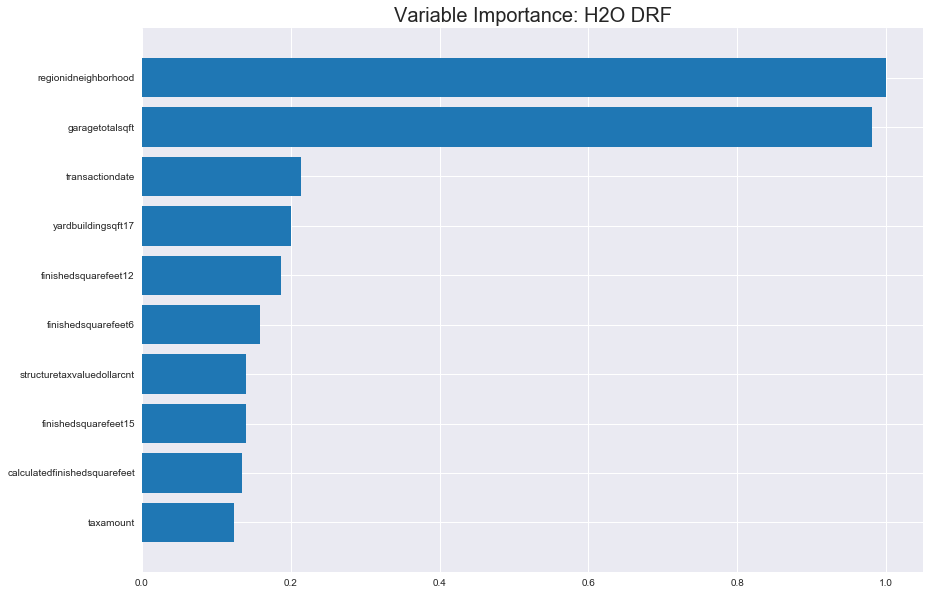

In [267]:
mod,mod_id=get_model_by_algo("XRT",models_dict)
if mod is not None:
  print(mod_id)
  print(mod.algo)
  mod.varimp_plot()

In [268]:
penalty=0.9
if mod is not None:
  l=mod.varimp()
  for v in l:
    if v[0] in varimp:   
      varimp[v[0]]=((v[2]+varimp[v[0]])/2)
    else:   
      varimp[v[0]]=(v[2]*penalty)    

In [269]:
varimp

{'airconditioningtypeid': 0.05141151458706515,
 'architecturalstyletypeid': 0.00046464485054704795,
 'basementsqft': 0.0026241165742099384,
 'bathroomcnt': 0.07274506024705465,
 'bedroomcnt': 0.1305713849157399,
 'buildingclasstypeid': 0.006877635985929468,
 'buildingqualitytypeid': 0.09369778554278294,
 'calculatedbathnbr': 0.10344769456216321,
 'calculatedfinishedsquarefeet': 0.26966102743002024,
 'censustractandblock': 0.046362481746277634,
 'decktypeid': 0.0014537852687852197,
 'finishedfloor1squarefeet': 0.0432001399990304,
 'finishedsquarefeet12': 0.32364493082011925,
 'finishedsquarefeet13': 0.0011657648706583884,
 'finishedsquarefeet15': 0.17175445575841458,
 'finishedsquarefeet50': 0.0557225633175046,
 'finishedsquarefeet6': 0.16273612228501427,
 'fips': 0.0016128368320534946,
 'fireplacecnt': 0.025245995937445663,
 'fireplaceflag': 5.386605442542235e-05,
 'fullbathcnt': 0.10107202745603537,
 'garagecarcnt': 0.02224045959906754,
 'garagetotalsqft': 0.9902905056682907,
 'hashot

#### Properties Set Missing Values:
first, we need to check the missing values of each colunm. Some data will not be used to predict the price if too many missing values included.

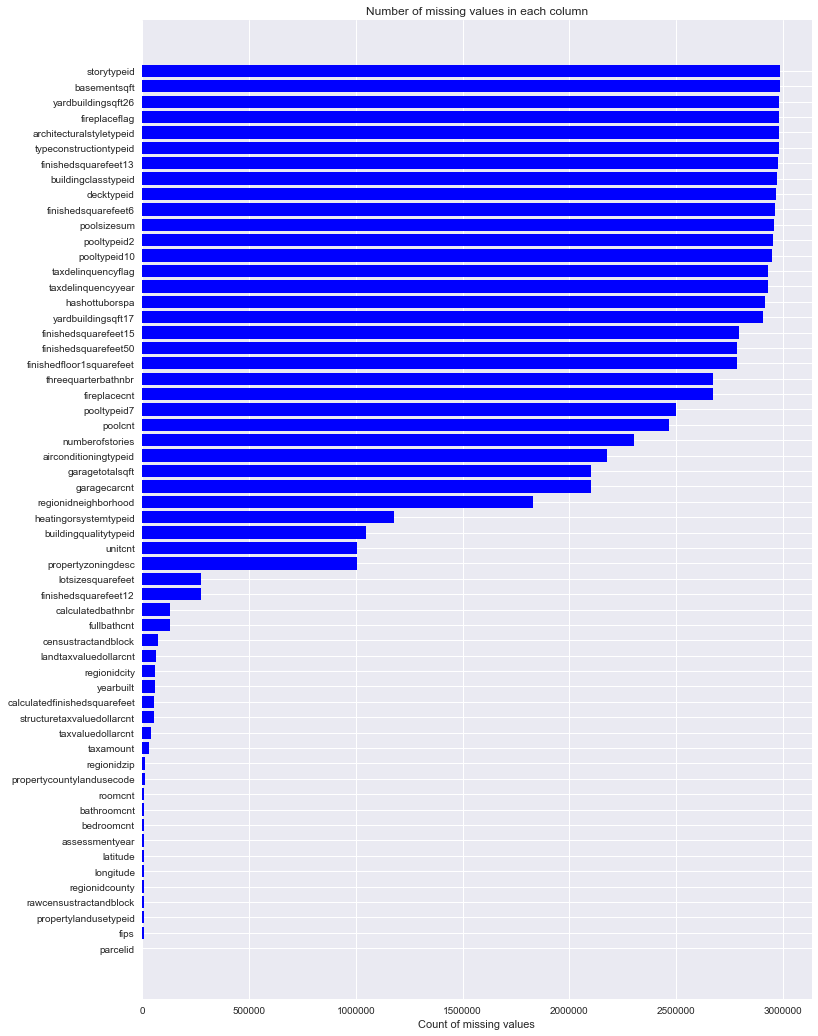

In [270]:
# define the properties missing value variable
properties_missing_df = properties_2016.isnull().sum(axis=0).reset_index()
properties_missing_df.columns = ['column_name', 'missing_count']
properties_missing_df = properties_missing_df.ix[properties_missing_df['missing_count']>=0]
properties_missing_df = properties_missing_df.sort_values(by='missing_count')

# set the size and shape of the grapgh
ind = np.arange(properties_missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, properties_missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(properties_missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")

# show the graph
plt.show()

In [271]:
properties_missing_df.head()

,column_name,missing_count
0,parcelid,0
17,fips,11437
33,propertylandusetypeid,11437
35,rawcensustractandblock,11437
37,regionidcounty,11437


### Missing and uniques in H2O

Let's calculate total counts, missing, uniques using H2O rather than Pandas.



In [272]:
def get_variable_names(df):
    d={}
    n={} 
    e={}    
    for key, val in df.types.items():
      if val in ['real','int','enum']:
         d[key]=val
      if val in ['real','int']:
         n[key]=val            
      if val in ['enum']:
         e[key]=val            
    return  d,n, e

In [273]:
nvalue = float('NaN')
print(nvalue)

nan


In [274]:
hf_counts={}
v,ir,e=get_variable_names(hf)
print(v)

{'parcelid': 'int', 'airconditioningtypeid': 'enum', 'architecturalstyletypeid': 'enum', 'basementsqft': 'enum', 'bathroomcnt': 'real', 'bedroomcnt': 'int', 'buildingclasstypeid': 'enum', 'buildingqualitytypeid': 'int', 'calculatedbathnbr': 'real', 'decktypeid': 'enum', 'finishedfloor1squarefeet': 'enum', 'calculatedfinishedsquarefeet': 'int', 'finishedsquarefeet12': 'int', 'finishedsquarefeet13': 'enum', 'finishedsquarefeet15': 'enum', 'finishedsquarefeet50': 'enum', 'finishedsquarefeet6': 'enum', 'fips': 'int', 'fireplacecnt': 'enum', 'fullbathcnt': 'int', 'garagecarcnt': 'enum', 'garagetotalsqft': 'enum', 'hashottuborspa': 'enum', 'heatingorsystemtypeid': 'int', 'latitude': 'int', 'longitude': 'int', 'lotsizesquarefeet': 'real', 'poolcnt': 'enum', 'poolsizesum': 'enum', 'pooltypeid10': 'enum', 'pooltypeid2': 'enum', 'pooltypeid7': 'enum', 'propertycountylandusecode': 'int', 'propertylandusetypeid': 'int', 'propertyzoningdesc': 'enum', 'rawcensustractandblock': 'real', 'regionidcity'

In [275]:
num_fields=list(ir.keys())
num_fields

['parcelid',
 'bathroomcnt',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fips',
 'fullbathcnt',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'roomcnt',
 'unitcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'taxamount',
 'censustractandblock',
 'logerror']

In [276]:
hf_num_fields=hf[:,num_fields]

In [277]:
hf_num_fields.head()

parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror
1.70738e+07,2.5,3,nan,2.5,1264,1264,6111,2,nan,3.43036e+07,-1.19287e+08,1735,1128,265,6.111e+07,34543,2061,97081,5,nan,1986,115087,191811,2015,76724,2015.06,6.111e+13,0.0953
1.7089e+07,1,2,nan,1,777,777,6111,1,nan,3.42729e+07,-1.19199e+08,nan,1129,266,6.111e+07,34543,2061,97083,4,nan,1990,143809,239679,2015,95870,2581.3,6.111e+13,0.0198
1.71004e+07,2,3,nan,2,1101,1101,6111,2,nan,3.43408e+07,-1.1908e+08,6569,1111,261,6.111e+07,26965,2061,97113,5,nan,1956,33619,47853,2015,14234,591.64,6.111e+13,0.006
1.71024e+07,1.5,2,nan,1.5,1554,1554,6111,1,nan,3.43543e+07,-1.19076e+08,7400,1110,261,6.111e+07,26965,2061,97113,5,nan,1965,45609,62914,2015,17305,682.78,6.111e+13,-0.0566
1.71096e+07,2.5,4,nan,2.5,2415,2415,6111,2,nan,3.42666e+07,-1.19165e+08,6326,1111,261,6.111e+07,34543,2061,97084,8,nan,1984,277000,554000,2015,277000,5886.92,6.111e+13,0.0573
1.71258e+07,2.5,4,nan,2.5,2882,2882,6111,2,nan,3.424e+07,-1.19025e+08,10000,1111,261,6.11101e+07,51239,2061,97089,8,nan,1980,222070,289609,2015,67539,3110.44,6.11101e+13,0.0564
1.71329e+07,2,3,nan,2,1772,1772,6111,2,nan,3.42268e+07,-1.1906e+08,8059,1111,261,6.11101e+07,51239,2061,97089,6,nan,1978,185000,526000,2015,341000,5632.2,6.11101e+13,0.0315
1.71349e+07,2.5,5,nan,2.5,2632,2632,6111,2,nan,3.42298e+07,-1.1905e+08,7602,1111,261,6.11101e+07,51239,2061,97089,8,nan,1971,342611,571086,2015,228475,6109.94,6.11101e+13,0.0257
1.714e+07,2,3,nan,2,1292,1292,6111,2,nan,3.42264e+07,-1.18984e+08,7405,1111,261,6.11101e+07,51239,2061,97091,6,nan,1979,231297,462594,2015,231297,5026.4,6.11101e+13,0.002
1.71674e+07,1,3,nan,1,1385,1385,6111,1,nan,3.41793e+07,-1.19169e+08,6000,1111,261,6.111e+07,13150,2061,97104,6,nan,1950,134251,268502,2015,134251,3217.06,6.111e+13,-0.0576


In [278]:
hf_num_fields.describe()

Rows:90275
Cols:29




,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror
type,int,real,int,int,real,int,int,int,int,int,int,int,real,int,int,real,int,int,int,int,int,int,int,int,int,int,real,int,real
mins,10711738.0,0.0,0.0,1.0,1.0,2.0,2.0,6037.0,1.0,1.0,33339295.0,-119447865.0,167.0,0.0,31.0,60371011.101001,3491.0,1286.0,95982.0,0.0,1.0,1885.0,100.0,22.0,2015.0,22.0,49.08,60371011101001.0,-4.605
mean,12984656.108712273,2.279473829964004,3.0318692882857903,5.56540687539223,2.3092162122725703,1773.1859865645972,1745.4545305855427,6048.870551093871,2.241231073148282,3.9269793152639108,34005410.69369153,-118198868.30685127,29110.164176624,202.6997234028199,261.83217945167587,60491794.811502874,33761.332851071544,2525.420769869842,96586.1311835106,1.4785156466352813,1.1104142032114885,1968.5328701169585,180093.39374826167,457672.6273567132,2015.0,278335.3250216003,5983.975926730117,60491508546032.64,0.011457219606757121
maxs,162960842.0,20.0,16.0,12.0,20.0,22741.0,20013.0,6111.0,20.0,24.0,34816009.0,-117554924.0,6971010.0,8800.0,275.0,61110091.00101999,396556.0,3101.0,399675.0,18.0,143.0,2015.0,9948100.0,27750000.0,2015.0,24500000.0,321936.09,61110091001020.0,4.737
sigma,2504510.488301767,1.0042709877071905,1.1564355198675524,1.9006016285969731,0.9761724992343213,928.1623927208233,909.9411657489271,20.663460805186414,0.9631416217273226,3.6843820505313793,264965.37555690156,360603.19970355544,121721.30865440037,307.47152682954317,5.182900523458312,205054.86726826307,46672.39386291222,805.6948419923104,3661.3390937511517,2.819627043522205,0.7972352624935555,23.76347471454321,209129.88816860024,554884.3989425417,0.0,400495.4648926158,6838.876956292304,204660503527.13788,0.1610788353671869
zeros,0,1165,1421,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,69700,0,0,0,0,0,0,0,0,847
missing,0,0,0,32911,1182,661,4679,0,1182,34195,0,0,10150,16160,0,0,1803,0,35,0,31922,756,380,1,0,1,6,605,0
0,17073783.0,2.5,3.0,nan,2.5,1264.0,1264.0,6111.0,2.0,nan,34303597.0,-119287236.0,1735.0,1128.0,265.0,61110022.003006995,34543.0,2061.0,97081.0,5.0,nan,1986.0,115087.0,191811.0,2015.0,76724.0,2015.06,61110022003007.0,0.0953
1,17088994.0,1.0,2.0,nan,1.0,777.0,777.0,6111.0,1.0,nan,34272866.0,-119198911.0,nan,1129.0,266.0,61110015.031002,34543.0,2061.0,97083.0,4.0,nan,1990.0,143809.0,239679.0,2015.0,95870.0,2581.3,61110015031002.0,0.0198
2,17100444.0,2.0,3.0,nan,2.0,1101.0,1101.0,6111.0,2.0,nan,34340801.0,-119079610.0,6569.0,1111.0,261.0,61110007.01100699,26965.0,2061.0,97113.0,5.0,nan,1956.0,33619.0,47853.0,2015.0,14234.0,591.64,61110007011007.0,0.006


In [279]:
enum_fields=list(e.keys())
enum_fields

['airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'buildingclasstypeid',
 'decktypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fireplacecnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertyzoningdesc',
 'regionidneighborhood',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'numberofstories',
 'fireplaceflag',
 'taxdelinquencyflag',
 'taxdelinquencyyear']

In [280]:
hf_enum_fields=hf[:,enum_fields]

In [281]:
hf_enum_fields.head()

airconditioningtypeid,architecturalstyletypeid,basementsqft,buildingclasstypeid,decktypeid,finishedfloor1squarefeet,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fireplacecnt,garagecarcnt,garagetotalsqft,hashottuborspa,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertyzoningdesc,regionidneighborhood,storytypeid,threequarterbathnbr,typeconstructiontypeid,yardbuildingsqft17,yardbuildingsqft26,numberofstories,fireplaceflag,taxdelinquencyflag,taxdelinquencyyear
nan,nan,nan,nan,nan,548,nan,nan,548,nan,nan,2,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,128,nan,2,nan,nan,nan
nan,nan,nan,nan,nan,777,nan,nan,777,nan,nan,1,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,198,nan,1,nan,nan,nan
nan,nan,nan,nan,nan,1101,nan,nan,1101,nan,nan,2,441,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan
nan,nan,nan,nan,nan,1554,nan,nan,1554,nan,1,2,460,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,1,nan,nan,nan
nan,nan,nan,nan,nan,1305,nan,nan,1305,nan,1,2,665,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,2,nan,nan,nan
nan,nan,nan,nan,66,1303,nan,nan,1303,nan,1,2,473,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,2,nan,nan,nan
nan,nan,nan,nan,nan,1772,nan,nan,1772,nan,1,2,467,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1045,nan,1,nan,nan,nan
nan,nan,nan,nan,nan,1240,nan,nan,1240,nan,1,2,440,nan,1,800,nan,nan,1,nan,nan,nan,1,nan,180,nan,2,nan,nan,nan
nan,nan,nan,nan,nan,1292,nan,nan,1292,nan,nan,2,494,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,304,nan,1,nan,nan,nan
nan,nan,nan,nan,nan,804,nan,nan,804,nan,1,1,253,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan


In [282]:
# get variable counts
for n in v.keys():
  try:
    l=[v[n]]
    l.append(int(hf[n].nrows))      
    try:
      nunique=int(len(hf[n].unique()))
    except:
      nunique=int(hf[n].nrows)    
    l.append(nunique) 
    l.append(int(hf[n].nacnt()[0])) 
    l.append((int(hf[n].nrows))-(int(hf[n].nacnt()[0])))     
    hf_counts[n]=l
  except:
    pass 

In [283]:
# nrows, nacnt, unique 
hf_counts

{'airconditioningtypeid': ['enum', 90275, 7, 0, 90275],
 'architecturalstyletypeid': ['enum', 90275, 7, 0, 90275],
 'assessmentyear': ['int', 90275, 1, 0, 90275],
 'basementsqft': ['enum', 90275, 40, 0, 90275],
 'bathroomcnt': ['real', 90275, 23, 0, 90275],
 'bedroomcnt': ['int', 90275, 17, 0, 90275],
 'buildingclasstypeid': ['enum', 90275, 2, 0, 90275],
 'buildingqualitytypeid': ['int', 90275, 9, 32911, 57364],
 'calculatedbathnbr': ['real', 90275, 23, 1182, 89093],
 'calculatedfinishedsquarefeet': ['int', 90275, 5103, 661, 89614],
 'censustractandblock': ['int', 90275, 42399, 605, 89670],
 'decktypeid': ['enum', 90275, 2, 0, 90275],
 'finishedfloor1squarefeet': ['enum', 90275, 1887, 0, 90275],
 'finishedsquarefeet12': ['int', 90275, 4983, 4679, 85596],
 'finishedsquarefeet13': ['enum', 90275, 12, 0, 90275],
 'finishedsquarefeet15': ['enum', 90275, 1916, 0, 90275],
 'finishedsquarefeet50': ['enum', 90275, 1899, 0, 90275],
 'finishedsquarefeet6': ['enum', 90275, 361, 0, 90275],
 'fips'

Many columns have many missing values, more can focus on the columns with more values.  
#### Choose colums according to missing value for properties:

In [284]:
# chose the top 23 variables of properties missing value
total_name = properties_missing_df.column_name.values[0:23]

# print the total name
print(total_name)

['parcelid' 'fips' 'propertylandusetypeid' 'rawcensustractandblock'
 'regionidcounty' 'longitude' 'latitude' 'assessmentyear' 'bedroomcnt'
 'bathroomcnt' 'roomcnt' 'propertycountylandusecode' 'regionidzip'
 'taxamount' 'taxvaluedollarcnt' 'structuretaxvaluedollarcnt'
 'calculatedfinishedsquarefeet' 'yearbuilt' 'regionidcity'
 'landtaxvaluedollarcnt' 'censustractandblock' 'fullbathcnt'
 'calculatedbathnbr']


# Indpendent variables based on variable importance

Lets select indpendent variables based on variable importance and data types.

In [285]:
varimp

{'airconditioningtypeid': 0.05141151458706515,
 'architecturalstyletypeid': 0.00046464485054704795,
 'basementsqft': 0.0026241165742099384,
 'bathroomcnt': 0.07274506024705465,
 'bedroomcnt': 0.1305713849157399,
 'buildingclasstypeid': 0.006877635985929468,
 'buildingqualitytypeid': 0.09369778554278294,
 'calculatedbathnbr': 0.10344769456216321,
 'calculatedfinishedsquarefeet': 0.26966102743002024,
 'censustractandblock': 0.046362481746277634,
 'decktypeid': 0.0014537852687852197,
 'finishedfloor1squarefeet': 0.0432001399990304,
 'finishedsquarefeet12': 0.32364493082011925,
 'finishedsquarefeet13': 0.0011657648706583884,
 'finishedsquarefeet15': 0.17175445575841458,
 'finishedsquarefeet50': 0.0557225633175046,
 'finishedsquarefeet6': 0.16273612228501427,
 'fips': 0.0016128368320534946,
 'fireplacecnt': 0.025245995937445663,
 'fireplaceflag': 5.386605442542235e-05,
 'fullbathcnt': 0.10107202745603537,
 'garagecarcnt': 0.02224045959906754,
 'garagetotalsqft': 0.9902905056682907,
 'hashot

In [286]:
list(v.keys())

['parcelid',
 'airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fips',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'numberofstories',
 'firep

In [287]:
def feature_selection(d,l, thresh=0.05):
    iv=[]
    for key in d.keys():
      if d[key]>thresh:
        iv.append(key)
    for v in iv:
        if v not in l:
            iv.remove(v)
    return iv

In [288]:
X=feature_selection(varimp,list(v.keys()))
print(X)

['garagetotalsqft', 'regionidneighborhood', 'finishedsquarefeet12', 'structuretaxvaluedollarcnt', 'yearbuilt', 'calculatedfinishedsquarefeet', 'taxamount', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'latitude', 'lotsizesquarefeet', 'propertyzoningdesc', 'bedroomcnt', 'finishedsquarefeet15', 'longitude', 'yardbuildingsqft17', 'finishedsquarefeet6', 'fullbathcnt', 'calculatedbathnbr', 'regionidcity', 'buildingqualitytypeid', 'bathroomcnt', 'finishedsquarefeet50', 'parcelid', 'propertycountylandusecode', 'regionidzip', 'taxdelinquencyyear', 'airconditioningtypeid']


In [289]:
print(y)
if y in X:
  X.remove(y) 

logerror


In [290]:
Xy=[y]
for i in X:
  Xy.append(i)
print(X)
print(Xy)

['garagetotalsqft', 'regionidneighborhood', 'finishedsquarefeet12', 'structuretaxvaluedollarcnt', 'yearbuilt', 'calculatedfinishedsquarefeet', 'taxamount', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'latitude', 'lotsizesquarefeet', 'propertyzoningdesc', 'bedroomcnt', 'finishedsquarefeet15', 'longitude', 'yardbuildingsqft17', 'finishedsquarefeet6', 'fullbathcnt', 'calculatedbathnbr', 'regionidcity', 'buildingqualitytypeid', 'bathroomcnt', 'finishedsquarefeet50', 'parcelid', 'propertycountylandusecode', 'regionidzip', 'taxdelinquencyyear', 'airconditioningtypeid']
['logerror', 'garagetotalsqft', 'regionidneighborhood', 'finishedsquarefeet12', 'structuretaxvaluedollarcnt', 'yearbuilt', 'calculatedfinishedsquarefeet', 'taxamount', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'latitude', 'lotsizesquarefeet', 'propertyzoningdesc', 'bedroomcnt', 'finishedsquarefeet15', 'longitude', 'yardbuildingsqft17', 'finishedsquarefeet6', 'fullbathcnt', 'calculatedbathnbr', 'regionidcity', 'buildingqu

In [291]:
hf_scrubbed=hf[:,Xy]

In [292]:
hf_scrubbed.head()

logerror,garagetotalsqft,regionidneighborhood,finishedsquarefeet12,structuretaxvaluedollarcnt,yearbuilt,calculatedfinishedsquarefeet,taxamount,taxvaluedollarcnt,landtaxvaluedollarcnt,latitude,lotsizesquarefeet,propertyzoningdesc,bedroomcnt,finishedsquarefeet15,longitude,yardbuildingsqft17,finishedsquarefeet6,fullbathcnt,calculatedbathnbr,regionidcity,buildingqualitytypeid,bathroomcnt,finishedsquarefeet50,parcelid,propertycountylandusecode,regionidzip,taxdelinquencyyear,airconditioningtypeid
0.0953,0,nan,1264,115087,1986,1264,2015.06,191811,76724,3.43036e+07,1735,nan,3,nan,-1.19287e+08,128,nan,2,2.5,34543,nan,2.5,548,1.70738e+07,1128,97081,nan,nan
0.0198,0,nan,777,143809,1990,777,2581.3,239679,95870,3.42729e+07,nan,nan,2,nan,-1.19199e+08,198,nan,1,1,34543,nan,1,777,1.7089e+07,1129,97083,nan,nan
0.006,441,nan,1101,33619,1956,1101,591.64,47853,14234,3.43408e+07,6569,nan,3,nan,-1.1908e+08,nan,nan,2,2,26965,nan,2,1101,1.71004e+07,1111,97113,nan,nan
-0.0566,460,nan,1554,45609,1965,1554,682.78,62914,17305,3.43543e+07,7400,nan,2,nan,-1.19076e+08,nan,nan,1,1.5,26965,nan,1.5,1554,1.71024e+07,1110,97113,nan,nan
0.0573,665,nan,2415,277000,1984,2415,5886.92,554000,277000,3.42666e+07,6326,nan,4,nan,-1.19165e+08,nan,nan,2,2.5,34543,nan,2.5,1305,1.71096e+07,1111,97084,nan,nan
0.0564,473,nan,2882,222070,1980,2882,3110.44,289609,67539,3.424e+07,10000,nan,4,nan,-1.19025e+08,nan,nan,2,2.5,51239,nan,2.5,1303,1.71258e+07,1111,97089,nan,nan
0.0315,467,nan,1772,185000,1978,1772,5632.2,526000,341000,3.42268e+07,8059,nan,3,nan,-1.1906e+08,1045,nan,2,2,51239,nan,2,1772,1.71329e+07,1111,97089,nan,nan
0.0257,440,nan,2632,342611,1971,2632,6109.94,571086,228475,3.42298e+07,7602,nan,5,nan,-1.1905e+08,180,nan,2,2.5,51239,nan,2.5,1240,1.71349e+07,1111,97089,nan,nan
0.002,494,nan,1292,231297,1979,1292,5026.4,462594,231297,3.42264e+07,7405,nan,3,nan,-1.18984e+08,304,nan,2,2,51239,nan,2,1292,1.714e+07,1111,97091,nan,nan
-0.0576,253,nan,1385,134251,1950,1385,3217.06,268502,134251,3.41793e+07,6000,nan,3,nan,-1.19169e+08,nan,nan,1,1,13150,nan,1,804,1.71674e+07,1111,97104,nan,nan


In [293]:
def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x

In [294]:
X_all=get_independent_variables(train,y)
print(X_all)
print(len(X_all))

['parcelid', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips', 'fullbathcnt', 'heatingorsystemtypeid', 'latitude', 'longitude', 'propertycountylandusecode', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 'censustractandblock', 'airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertyzoningdesc', 'regionidneighborhood', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag', 'tax

In [295]:
print(X)
print(len(X))

['garagetotalsqft', 'regionidneighborhood', 'finishedsquarefeet12', 'structuretaxvaluedollarcnt', 'yearbuilt', 'calculatedfinishedsquarefeet', 'taxamount', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'latitude', 'lotsizesquarefeet', 'propertyzoningdesc', 'bedroomcnt', 'finishedsquarefeet15', 'longitude', 'yardbuildingsqft17', 'finishedsquarefeet6', 'fullbathcnt', 'calculatedbathnbr', 'regionidcity', 'buildingqualitytypeid', 'bathroomcnt', 'finishedsquarefeet50', 'parcelid', 'propertycountylandusecode', 'regionidzip', 'taxdelinquencyyear', 'airconditioningtypeid']
28


In [296]:
aml.train(x=X_all,y=y,training_frame=train) 

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [297]:
print(aml.leaderboard)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20190218_225558,0.0253171,0.159114,0.0253171,0.0682536,nan
StackedEnsemble_BestOfFamily_AutoML_20190218_225558,0.0253171,0.159114,0.0253171,0.0682536,nan
XGBoost_1_AutoML_20190218_230151,0.0254015,0.159378,0.0254015,0.0684061,nan
XGBoost_1_AutoML_20190218_225558,0.0254222,0.159444,0.0254222,0.0684169,nan
XRT_1_AutoML_20190218_225558,0.0255347,0.159796,0.0255347,0.06863,nan
XRT_1_AutoML_20190218_230151,0.0255681,0.1599,0.0255681,0.068737,nan
GLM_grid_1_AutoML_20190218_225558_model_1,0.0255774,0.159929,0.0255774,0.0681765,nan
GLM_grid_1_AutoML_20190218_230151_model_1,0.0255774,0.159929,0.0255774,0.0681765,nan
DRF_1_AutoML_20190218_225558,0.0257977,0.160617,0.0257977,0.0702727,nan
DRF_1_AutoML_20190218_230151,0.0259102,0.160966,0.0259102,0.0703762,nan


In [298]:
aml.train(x=X,y=y,training_frame=hf_scrubbed)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [299]:
print(aml.leaderboard)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20190218_225558,0.0253171,0.159114,0.0253171,0.0682536,nan
StackedEnsemble_BestOfFamily_AutoML_20190218_225558,0.0253171,0.159114,0.0253171,0.0682536,nan
XGBoost_1_AutoML_20190218_230151,0.0254015,0.159378,0.0254015,0.0684061,nan
XGBoost_1_AutoML_20190218_225558,0.0254222,0.159444,0.0254222,0.0684169,nan
XRT_1_AutoML_20190218_225558,0.0255347,0.159796,0.0255347,0.06863,nan
XRT_1_AutoML_20190218_230151,0.0255681,0.1599,0.0255681,0.068737,nan
GLM_grid_1_AutoML_20190218_225558_model_1,0.0255774,0.159929,0.0255774,0.0681765,nan
GLM_grid_1_AutoML_20190218_230151_model_1,0.0255774,0.159929,0.0255774,0.0681765,nan
XGBoost_1_AutoML_20190218_230729,0.0257691,0.160527,0.0257691,0.0686501,nan
DRF_1_AutoML_20190218_225558,0.0257977,0.160617,0.0257977,0.0702727,nan


In [300]:
def get_scrubbed_name(p):
  n=''
  (data_root, data_ext) = os.path.splitext(p)
  data_names=data_root.split('/')
  n=data_names[-1]+'_scrubbed'+data_ext
  return n  

In [301]:
n=get_scrubbed_name(data_file)
print(n)

properties_2016_scrubbed.csv


In [302]:
h2o.export_file(hf_scrubbed, n, force=True)

Export File progress: |███████████████████████████████████████████████████| 100%


In [303]:
h2o.cluster().shutdown()

H2O session _sid_9230 closed.
